In [1]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [2]:
path = Config().data_path()/'mnist'

In [3]:
path

WindowsPath('C:/Users/Tim/.fastai/data/mnist')

In [5]:
path.ls()

[WindowsPath('C:/Users/Tim/.fastai/data/mnist/mnist.pkl.gz')]

In [6]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

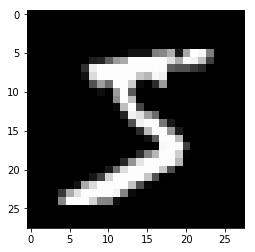

In [10]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [11]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In [12]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [13]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [14]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): return self.lin(xb)

In [15]:
model = Mnist_Logistic().cuda()

In [16]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [17]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [18]:
model(x).shape

torch.Size([64, 10])

In [19]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [20]:
lr=2e-2

In [21]:
loss_func = nn.CrossEntropyLoss()

In [24]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2=0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
            
    return loss.item()

In [25]:
losses = [update(x,y,lr) for x,y in data.train_dl]

In [26]:
losses

[2.3123390674591064,
 2.2960007190704346,
 2.296308994293213,
 2.2707791328430176,
 2.232548713684082,
 2.2024331092834473,
 2.178837299346924,
 2.1480491161346436,
 2.1335766315460205,
 2.1341214179992676,
 2.1300272941589355,
 2.0634801387786865,
 2.083730936050415,
 2.0279736518859863,
 2.0481834411621094,
 1.9978371858596802,
 1.9580291509628296,
 1.9787030220031738,
 2.0071792602539062,
 1.9478449821472168,
 1.9447617530822754,
 1.9455760717391968,
 1.8787156343460083,
 1.8370319604873657,
 1.8746486902236938,
 1.846947193145752,
 1.818721890449524,
 1.8877766132354736,
 1.8027275800704956,
 1.79306960105896,
 1.7119311094284058,
 1.7499892711639404,
 1.7003599405288696,
 1.7869834899902344,
 1.7999361753463745,
 1.7657846212387085,
 1.6570099592208862,
 1.6952111721038818,
 1.7202006578445435,
 1.6144765615463257,
 1.7239534854888916,
 1.7101821899414062,
 1.595996618270874,
 1.6002148389816284,
 1.634770154953003,
 1.672638177871704,
 1.5537930727005005,
 1.5575757026672363,
 1.

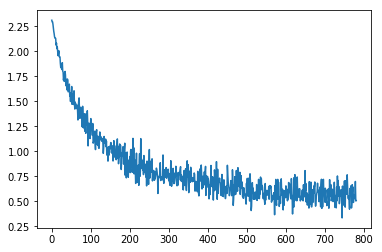

In [27]:
plt.plot(losses);

In [28]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 40, bias=True)
        self.lin2 = nn.Linear(40, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [29]:

model = Mnist_NN().cuda()

In [30]:
losses = [update(x,y,lr) for x,y in data.train_dl]

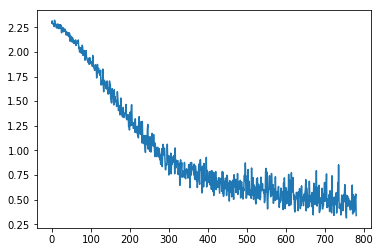

In [31]:
plt.plot(losses);

In [32]:
model = Mnist_NN().cuda()

In [33]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [34]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

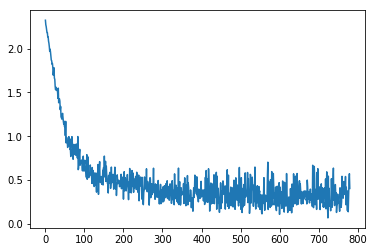

In [35]:
plt.plot(losses)

In [36]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [37]:
%debug

> <ipython-input-22-f0137951272f>(5)update()
      3     y_hat = model(x)
      4     # weight decay
----> 5     for p in model.parameters(): w2 += (p**2).sum()
      6     # add to regular loss
      7     loss = loss_func(y_hat, y) + w2*wd

ipdb> 
ipdb> 
ipdb> u
> <ipython-input-23-36d1490bd9f3>(1)<listcomp>()
----> 1 losses = [update(x,y,lr) for x,y in data.train_dl]

ipdb> print(k)
*** NameError: name 'k' is not defined
ipdb> loss_func
CrossEntropyLoss()
ipdb> q


In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


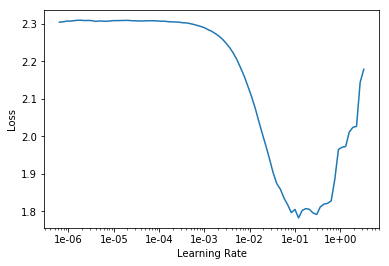

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.154231,0.142963,0.958700,00:23


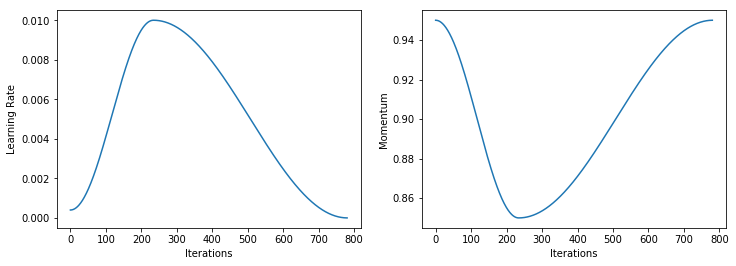

In [41]:
learn.recorder.plot_lr(show_moms=True)

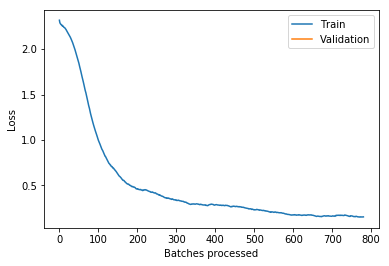

In [42]:
learn.recorder.plot_losses()

In [43]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.119562,0.117384,0.964900,00:25
